In [1]:
from collections import defaultdict
from pathlib import Path

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyprojroot
import seaborn as sns

import searchnets

In [2]:
def cm_to_inches(cm):
    return cm / 2.54

In [3]:
mpl.style.use(['seaborn-darkgrid', 'seaborn-paper'])

paths

In [4]:
ROOT = pyprojroot.here()
DATA_DIR = ROOT.joinpath('data')
RESULTS_ROOT = ROOT.joinpath('results')

SEARCHSTIMS_ROOT = RESULTS_ROOT.joinpath('searchstims')
RESULTS_GZ_ROOT = SEARCHSTIMS_ROOT.joinpath('results_gz')

SEARCHSTIMS_OUTPUT_ROOT = ROOT.joinpath('../visual_search_stimuli')
alexnet_data_csv_path = SEARCHSTIMS_OUTPUT_ROOT.joinpath(
    'alexnet_multiple_stims/alexnet_multiple_stims_128000samples_balanced_split.csv')
VGG16_data_csv_path = SEARCHSTIMS_OUTPUT_ROOT.joinpath(
    'VGG16_multiple_stims/VGG16_multiple_stims_128000samples_balanced_split.csv'
)

constants

In [5]:
LEARNING_RATE = 1e-3

NET_NAMES = [
    'alexnet',
    'VGG16',
    'CORnet_Z',
    'CORnet_S',
]

METHODS = [
    'initialize',
    'transfer'
]

MODES = [
    'classify',
]

## munge results into a dataframe

In [10]:
df_list = []

for net_name in NET_NAMES:
    for method in METHODS:
        for mode in MODES:
            results_gz_path = sorted(RESULTS_GZ_ROOT.glob(f'**/*{net_name}*{method}*gz'))
            # remove results_gz from previous versions
            results_gz_path = [results_gz for results_gz in results_gz_path if 'old' not in str(results_gz)]

            if mode == 'classify':                
                results_gz_path = [results_gz for results_gz in results_gz_path if 'detect' not in str(results_gz)]
            elif mode == 'detect':
                results_gz_path = [results_gz for results_gz in results_gz_path if 'detect' in str(results_gz)]
            
            if net_name == 'alexnet':
                # remove control experiment
                results_gz_path = [results_gz for results_gz in results_gz_path if 'white_background' not in str(results_gz)]

            if len(results_gz_path) != 1:
                raise ValueError(f'found more than one results.gz file: {results_gz_path}')
            results_gz_path = results_gz_path[0]

            if net_name == 'alexnet' or 'CORnet' in net_name:
                csv_path = alexnet_data_csv_path
            elif net_name == 'VGG16':
                csv_path = VGG16_data_csv_path
            else:
                raise ValueError(f'no csv path defined for net_name: {net_name}')

            df = searchnets.analysis.searchstims.results_gz_to_df(results_gz_path, 
                                                                  csv_path, 
                                                                  net_name,
                                                                  method,
                                                                  mode,
                                                                  LEARNING_RATE)
            df_list.append(df)
            
df_all = pd.concat(df_list)

Get just the transfer learning results, then group by network, stimulus, and set size, and compute the mean accuracy for each set size.

In [6]:
TEMP_CSV = SEARCHSTIMS_ROOT.joinpath('TEMP_searchstims_df_all.csv')

save_csv = False
# to avoid accidentally over-writing
if save_csv:
    df_all.to_csv(TEMP_CSV)
else:
    df_all = pd.read_csv(TEMP_CSV)

In [7]:
df_transfer = df_all[df_all['method'] == 'transfer']
df_transfer_acc_mn = df_transfer.groupby(['net_name', 'stimulus', 'set_size']).agg({'accuracy':'mean'})
df_transfer_acc_mn = df_transfer_acc_mn.reset_index()

Make one more `DataFrame` where variable is difference of mean accuracies on set size 1 and set size 8.

We use this below to organize the figure, and to show a heatmap with a marginal distribution.

In [8]:
records = defaultdict(list)

for net_name in df_transfer_acc_mn['net_name'].unique():
    df_net = df_transfer_acc_mn[df_transfer_acc_mn['net_name'] == net_name]
    for stim in df_net['stimulus'].unique():
        df_stim = df_net[df_net['stimulus'] == stim]
        set_size_1_acc = df_stim[df_stim['set_size'] == 1]['accuracy'].values.item()
        set_size_8_acc = df_stim[df_stim['set_size'] == 8]['accuracy'].values.item()
        acc_diff = set_size_1_acc - set_size_8_acc
        records['net_name'].append(net_name)
        records['stimulus'].append(stim)
        records['set_size_1_acc'].append(set_size_1_acc)
        records['set_size_8_acc'].append(set_size_8_acc)
        records['acc_diff'].append(acc_diff)

df_acc_diff = pd.DataFrame.from_records(records)
df_acc_diff = df_acc_diff[['net_name', 'stimulus', 'set_size_1_acc', 'set_size_8_acc', 'acc_diff']]

columns will be stimuli, in increasing order of accuracy drop across models

In [16]:
stim_acc_diff_df = df_acc_diff.groupby(['stimulus']).agg({'acc_diff': 'mean', 'set_size_1_acc': 'mean'})
stim_acc_diff_df = stim_acc_diff_df.reset_index()
stim_acc_diff_df = stim_acc_diff_df.sort_values(by=['set_size_1_acc', 'acc_diff'], ascending=False)

FIG_COLUMNS = stim_acc_diff_df['stimulus'].values.tolist()
print(FIG_COLUMNS)

['Bx_v_RxRo', 'YT_v_BTBL', 'Bx_v_RxBo', 'RVvGV', 'RVvRHGV', 'PWVvPWHCV', 'PWVvCV', 'TvT', 'YT_v_BTYL', '2_v_5']


rows will be nets, in decreasing order of accuracy drops across stimuli

In [17]:
net_acc_diff_df = df_acc_diff.groupby(['net_name']).agg({'acc_diff': 'mean'})
net_acc_diff_df = net_acc_diff_df.reset_index()
net_acc_diff_df = net_acc_diff_df.sort_values(by='acc_diff', ascending=False)
net_acc_diff_df

FIG_ROWS = net_acc_diff_df['net_name'].values.tolist()
print(FIG_ROWS)

['CORnet_S', 'CORnet_Z', 'VGG16', 'alexnet']


## plot figure

In [11]:
pal = sns.color_palette("rocket", n_colors=6)

In [12]:
len(pal)

6

In [13]:
cmaps = {}
for net in ('alexnet', 'CORnet_Z', 'VGG16', 'CORnet_S'):
    cmaps[net] = {
        'transfer': {
            'unit_both': pal[3],
            'mn_both': pal[2],
        },
        'initialize': {
            'unit_both': pal[5],
            'mn_both': pal[4],            
        }
    }

In [14]:
UNIT_COLORS = {
    'present': 'violet',
    'absent': 'lightgreen',
    'both': 'darkgrey'
}

# default colors used for plotting mean across sampling units in each condition
MN_COLORS = {
    'present': 'magenta',
    'absent': 'lawngreen',
    'both': 'black'
}


def metric_v_set_size_df(df, net_name, method, stimulus, metric, conditions,
                         unit_colors=UNIT_COLORS, mn_colors=MN_COLORS,
                         ax=None, title=None, save_as=None, figsize=(10, 5),
                         set_xlabel=False, set_ylabel=False, set_ylim=True,
                         ylim=(0, 1.1), yticks=None, plot_mean=True, add_legend=False, dpi=600):
    """plot accuracy as a function of visual search task set size
    for models trained on a single task or dataset

    Accepts a Pandas dataframe and column names that determine what to plot.
    Dataframe is produces by searchstims.utils.general.results_csv function.

    Parameters
    ----------
    df : pandas.Dataframe
        path to results.gz file saved after measuring accuracy of trained networks
        on test set of visual search stimuli
    net_name : str
        name of neural net architecture. Must be a value in the 'net_name' column
        of df.
    method : str
        method used for training. Must be a value in the 'method' column of df.
    stimulus : str
        type of visual search stimulus, e.g. 'RVvGV', '2_v_5'. Must be a value in
        the 'stimulus' column of df.
    metric : str
        metric to plot. One of {'acc', 'd_prime'}.
    conditions : list, str
        conditions to plot. One of {'present', 'absent', 'both'}. Corresponds to
        'target_condition' column in df.

    Other Parameters
    ----------------
    unit_colors : dict
        mapping of conditions to colors used for plotting 'sampling units', i.e. each trained
        network. Default is UNIT_COLORS defined in this module.
    mn_colors : dict
        mapping of conditions to colors used for plotting mean across 'sampling units'
        (i.e., each trained network). Default is MN_COLORS defined in this module.
    ax : matplotlib.Axis
        axis on which to plot figure. Default is None, in which case a new figure with
        a single axis is created for the plot.
    title : str
        string to use as title of figure. Default is None.
    save_as : str
        path to directory where figure should be saved. Default is None, in which
        case figure is not saved.
    figsize : tuple
        (width, height) in inches. Default is (10, 5). Only used if ax is None and a new
        figure is created.
    set_xlabel : bool
        if True, set the value of xlabel to "set size". Default is False.
    set_ylabel : bool
        if True, set the value of ylabel to metric. Default is False.
    set_ylim : bool
        if True, set the y-axis limits to the value of ylim.
    ylim : tuple
        with two elements, limits for y-axis. Default is (0, 1.1).
    plot_mean : bool
        if True, find mean accuracy and plot as a separate solid line. Default is True.
    add_legend : bool
        if True, add legend to axis. Default is False.

    Returns
    -------
    None
    """
    if ax is None:
        fig, ax = plt.subplots(dpi=dpi, figsize=figsize)

    df = df[(df['net_name'] == net_name)
            & (df['method'] == method)
            & (df['stimulus'] == stimulus)]
    
    if not all(
            [df['target_condition'].isin([targ_cond]).any() for targ_cond in conditions]
    ):
        raise ValueError(f'not all target conditions specified were found in dataframe.'
                         f'Target conditions specified were: {conditions}')

    handles = []
    labels = []

    set_sizes = None  # because we verify set sizes is the same across conditions
    net_nums = df['net_number'].unique()
    # get metric across set sizes for each training replicate
    # we end up with a list of vectors we can pass to ax.plot,
    # so that the 'line' for each training replicate gets plotted
    for targ_cond in conditions:
        metric_vals = []
        for net_num in net_nums:
            metric_vals.append(
                df[(df['net_number'] == net_num)
                   & (df['target_condition'] == targ_cond)][metric].values
            )

            curr_set_size = df[(df['net_number'] == net_num)
                               & (df['target_condition'] == targ_cond)]['set_size'].values
            if set_sizes is None:
                set_sizes = curr_set_size
            else:
                if not np.array_equal(set_sizes, curr_set_size):
                    raise ValueError(
                        f'set size for net number {net_num}, '
                        f'target condition {targ_cond},  did not match others'
                    )
        for row_num, arr_metric in enumerate(metric_vals):
            x = np.arange(1, len(set_sizes) + 1) * 2
            # just label first row, so only one entry shows up in legend
            if row_num == 0:
                label = f'training replicate, {method}'
            else:
                label = None
            ax.plot(x, arr_metric, color=unit_colors[targ_cond], linewidth=0.75,
                    linestyle='--', alpha=0.95, label=label)
            ax.set_xticks(x)
            ax.set_xticklabels(set_sizes)
            ax.set_xlim([0, x.max() + 2])

        if plot_mean:
            mn_metric = np.asarray(metric_vals).mean(axis=0)
            if targ_cond == 'both':
                mn_metric_label = f'mean, {method}'
            else:
                mn_metric_label = f'mean {metric}, {targ_cond}, {method}'
            labels.append(mn_metric_label)
            mn_metric_line, = ax.plot(x, mn_metric,
                                      color=mn_colors[targ_cond], linewidth=1.5, 
                                      alpha=0.65,
                                      label=mn_metric_label)
            ax.set_xticks(x)
            ax.set_xticklabels(set_sizes)
            ax.set_xlim([0, x.max() + 2])
            handles.append(mn_metric_line)

    if title:
        ax.set_title(title)
    if set_xlabel:
        ax.set_xlabel('set size')
    if set_ylabel:
        ax.set_ylabel(metric)
    if yticks is not None:
        ax.set_yticks(yticks)
    if set_ylim:
        ax.set_ylim(ylim)

    if add_legend:
        ax.legend(handles=handles,
                  labels=labels,
                  loc='lower left')

    if save_as:
        plt.savefig(save_as)

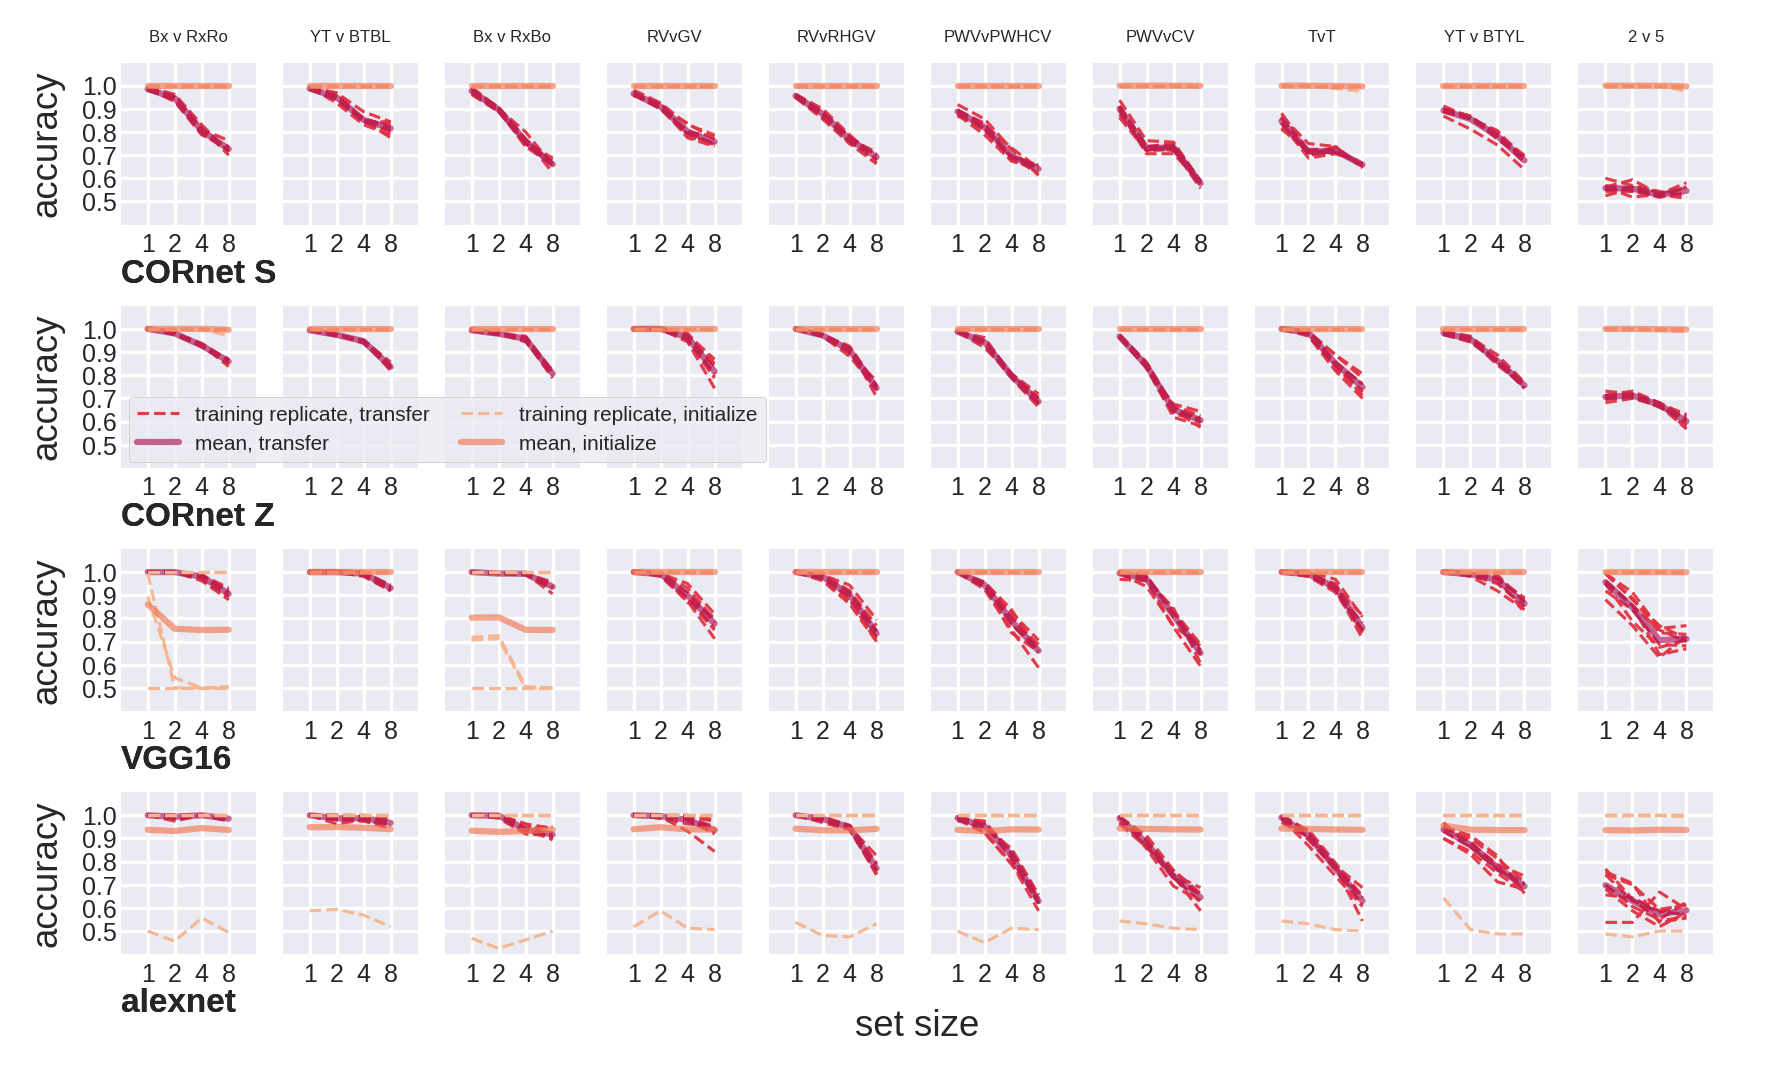

In [24]:
FIGSIZE = tuple(cm_to_inches(size) for size in (17.4, 10))
DPI = 300

n_rows = len(FIG_ROWS)
n_cols = len(FIG_COLUMNS)
fig, ax = plt.subplots(n_rows, n_cols, sharey=True, figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(hspace=0.5)

LABELSIZE = 6
XTICKPAD = 2
YTICKPAD = 1

for ax_ in ax.ravel():
    ax_.xaxis.set_tick_params(pad=XTICKPAD, labelsize=LABELSIZE)
    ax_.yaxis.set_tick_params(pad=YTICKPAD, labelsize=LABELSIZE)
    

STIM_FONTSIZE = 4

add_legend = False

for row, net_name in enumerate(FIG_ROWS):
    df_this_net = df_all[df_all['net_name'] == net_name]

    for method in ['transfer', 'initialize']:
        for col, stim_name in enumerate(FIG_COLUMNS):
                unit_colors = {'both': cmaps[net_name][method]['unit_both']}
                mn_colors = {'both': cmaps[net_name][method]['mn_both']}

                ax[row, col].set_axisbelow(True)  # so grid is behind
                metric_v_set_size_df(df=df_this_net, 
                                     net_name=net_name,
                                     method=method, 
                                     stimulus=stim_name,
                                     metric='accuracy', 
                                     conditions=['both'],
                                     unit_colors=unit_colors,
                                     mn_colors=mn_colors,
                                     set_ylim=True,
                                     ax=ax[row, col],
                                     ylim=(0.4, 1.1),
                                     yticks=(0.5, 0.6, 0.7, 0.8, 0.9, 1.0),
                                     add_legend=add_legend)
                

                if row == 0:
                    title = stim_name.replace('_',' ')
                    ax[row, col].set_title(title, 
                                           fontsize=STIM_FONTSIZE,
                                           pad=5)  # pad so we can put image over title without it showing
                if col == 0:
                    ax[row, col].set_ylabel('accuracy')
                    net_name_for_fig = net_name.replace('_', ' ')
                    ax[row, col].text(0, 0.15, net_name_for_fig, fontweight='bold', fontsize=8)

# add a big axis, hide frame
big_ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.grid(False)

handles, labels = ax[0, 0].get_legend_handles_labels()
LEGEND_FONTSIZE = 5
big_ax.legend(handles, labels, 
              bbox_to_anchor=(0.005, 0.55, 0.4, .075),
              ncol=2, mode="expand", frameon=True,
              borderaxespad=0., fontsize=LEGEND_FONTSIZE);

big_ax.set_xlabel("set size", labelpad=0.1);

for ext in ('svg', 'png'):
    fig_path = pyprojroot.here().joinpath(
        f'docs/paper/fig2/fig2.{ext}'
    )
    plt.savefig(fig_path)

In [24]:
FIG_ROWS

['CORnet_S', 'CORnet_Z', 'VGG16', 'alexnet']

In [24]:
df_acc_diff_pivot = df_acc_diff.pivot_table(index='net_name', columns='stimulus')
df_acc_diff_pivot.columns = df_acc_diff_pivot.columns.get_level_values(1)
df_acc_diff_stim_cols = pd.DataFrame(df_acc_diff_pivot.to_records())
df_acc_diff_stim_cols = df_acc_diff_stim_cols.set_index('net_name')
df_acc_diff_stim_cols.reindex(FIG_ROWS)
df_acc_diff_stim_cols = df_acc_diff_stim_cols[FIG_COLUMNS]
df_acc_diff_stim_cols

,Bx_v_RxRo,YT_v_BTBL,Bx_v_RxBo,2_v_5,RVvGV,YT_v_BTYL,RVvRHGV,TvT,PWVvPWHCV,PWVvCV
net_name,,,,,,,,,,
CORnet_S,0.140625,0.157812,0.186719,0.105469,0.183594,0.225781,0.255469,0.251563,0.301563,0.361719
CORnet_Z,0.140625,0.157812,0.186719,0.105469,0.183594,0.225781,0.255469,0.251563,0.301563,0.361719
VGG16,0.084375,0.066406,0.076563,0.250000,0.242969,0.133594,0.258594,0.205469,0.315625,0.325000
alexnet,0.017187,0.035156,0.092187,0.110938,0.042187,0.264062,0.233594,0.337500,0.362500,0.371875


In [25]:
acc_diff_mat = df_acc_diff_stim_cols.to_numpy()
acc_diff_stim_mean = acc_diff_mat.mean(0)
acc_diff_net_mean = acc_diff_mat.mean(1)

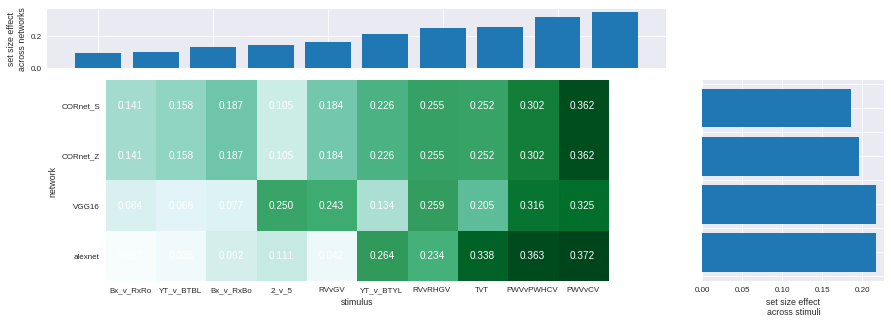

In [26]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 5))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])


ax_joint.imshow(acc_diff_mat, cmap=plt.get_cmap('BuGn'))
ax_joint.grid(False)
ax_joint.set_xticks(np.arange(acc_diff_mat.shape[1]))
ax_joint.set_yticks(np.arange(acc_diff_mat.shape[0]))
ax_joint.set_xticklabels(df_acc_diff_stim_cols.columns)
ax_joint.set_yticklabels(df_acc_diff_stim_cols.index.values)
for i in range(acc_diff_mat.shape[0]):
    for j in range(acc_diff_mat.shape[1]):
        text = ax_joint.text(j, i, f'{acc_diff_mat[i, j]:0.3f}', 
                             ha="center", va="center", color="w")

ax_marg_x.bar(np.arange(len(acc_diff_stim_mean)), acc_diff_stim_mean)
ax_marg_y.barh(np.arange(len(acc_diff_net_mean)), acc_diff_net_mean)

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('stimulus')
ax_joint.set_ylabel('network')

# Set labels on marginals
ax_marg_y.set_xlabel('set size effect\nacross stimuli')
ax_marg_x.set_ylabel('set size effect\nacross networks')
plt.show()

In [19]:
df[(df['net_name'] == net_name)
    & (df['method'] == method)
    % (df['mode'] == mode)
    & (df['stimulus'] == stimulus)]

,Unnamed: 0,net_name,method,mode,learning_rate,net_number,stimulus,set_size,target_condition,accuracy,hit_rate,false_alarm_rate,d_prime
0,0,alexnet,initialize,classify,0.001,1,RVvGV,1,present,1.0,NaN,NaN,NaN
1,1,alexnet,initialize,classify,0.001,1,RVvGV,2,present,1.0,NaN,NaN,NaN
2,2,alexnet,initialize,classify,0.001,1,RVvGV,4,present,1.0,NaN,NaN,NaN
3,3,alexnet,initialize,classify,0.001,1,RVvGV,8,present,1.0,NaN,NaN,NaN
4,4,alexnet,initialize,classify,0.001,1,RVvGV,1,absent,1.0,NaN,NaN,NaN


In [22]:
method

'transfer'

In [36]:
figsize=(25,4)

FONTSIZE = 24


def plot_classify_and_detect(df, net_name, cmaps, conditions, methods=['transfer', 'initialize'], fig_columns=FIG_COLUMNS):

    for mode in ['classify', 'detect']:
        fig, ax = plt.subplots(1, 10, sharex=True, sharey=True, figsize=figsize)
        for axis in ax:
            for item in ([axis.title, axis.xaxis.label, axis.yaxis.label] +
                         axis.get_xticklabels() + axis.get_yticklabels()):
                item.set_fontsize(FONTSIZE)

        # add a big axis, hide frame
        fig.add_subplot(111, frameon=False)

        # hide tick and tick label of the big axis
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

        for method in methods:
            for col, stim_name in enumerate(fig_columns):
                if conditions == ['both']:
                    unit_colors = {'both': cmaps[net_name][method]['unit_both']}
                    mn_colors = {'both': cmaps[net_name][method]['mn_both']}
                else:
                    unit_colors=searchnets.plot.setsize.UNIT_COLORS
                    mn_colors=searchnets.plot.setsize.MN_COLORS

                searchnets.plot.metric_v_set_size_df(df=df, 
                                                     net_name=net_name,
                                                     method=method,
                                                     mode=mode,
                                                     stimulus=stim_name,
                                                     metric='accuracy', 
                                                     conditions=conditions,
                                                     unit_colors=unit_colors,
                                                     mn_colors=mn_colors,
                                                     set_ylim=False,
                                                     ax=ax[col],
                                                     ylim=(0.5, 1.05),
                                                     add_legend=False)
                ax[col].set_title(stim_name)

        handles, labels = ax[0].get_legend_handles_labels()
        plt.legend(handles, labels, bbox_to_anchor=(0., -0.2, 0.65, .102), loc='upper left',
                   ncol=2, mode="expand", borderaxespad=0., fontsize=FONTSIZE);

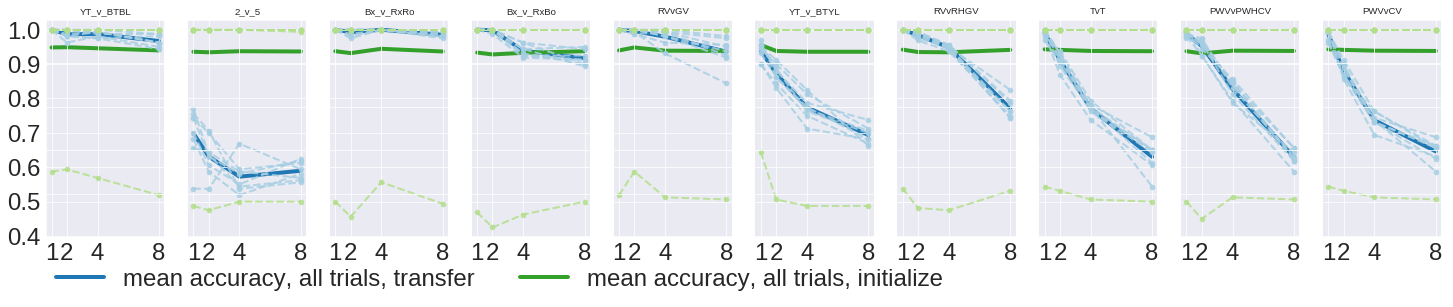

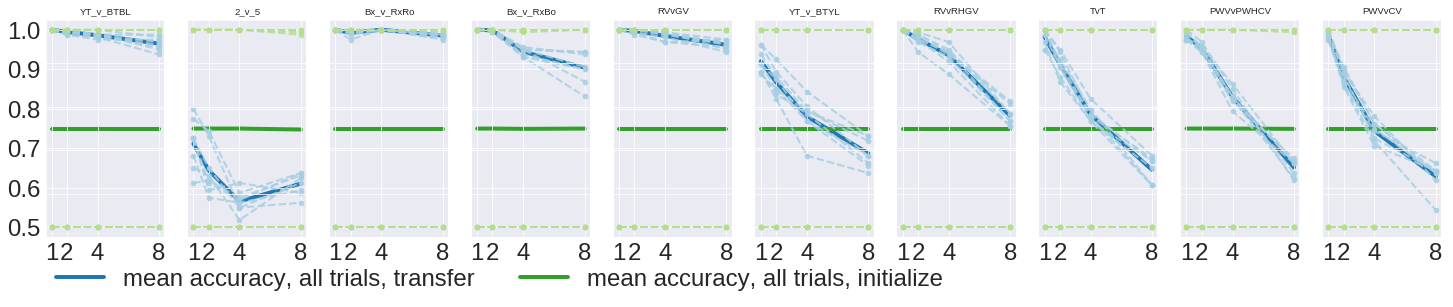

In [37]:
plot_classify_and_detect(df_all, 'alexnet', cmaps, conditions=['both'])

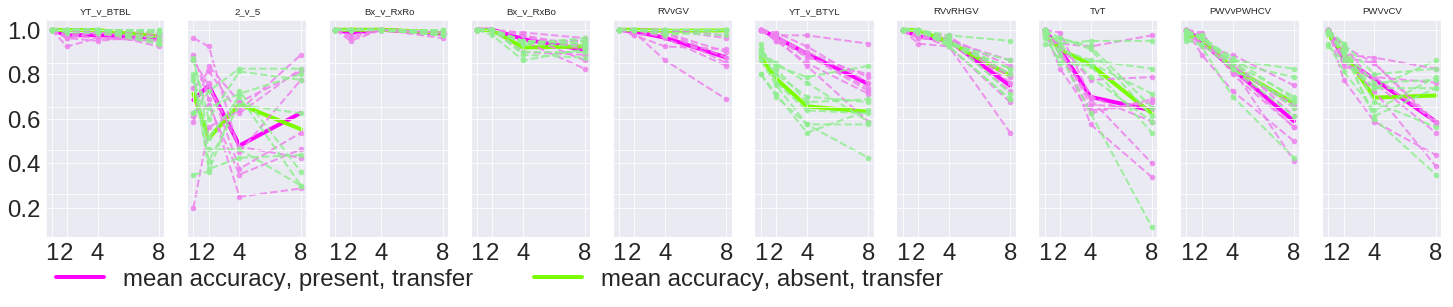

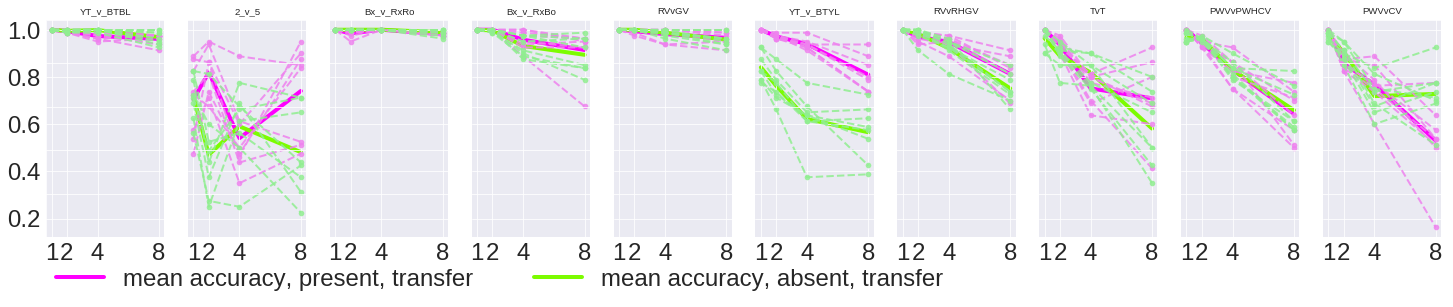

In [38]:
plot_classify_and_detect(df_all, 'alexnet', cmaps, conditions=['present', 'absent'], methods=['transfer'])

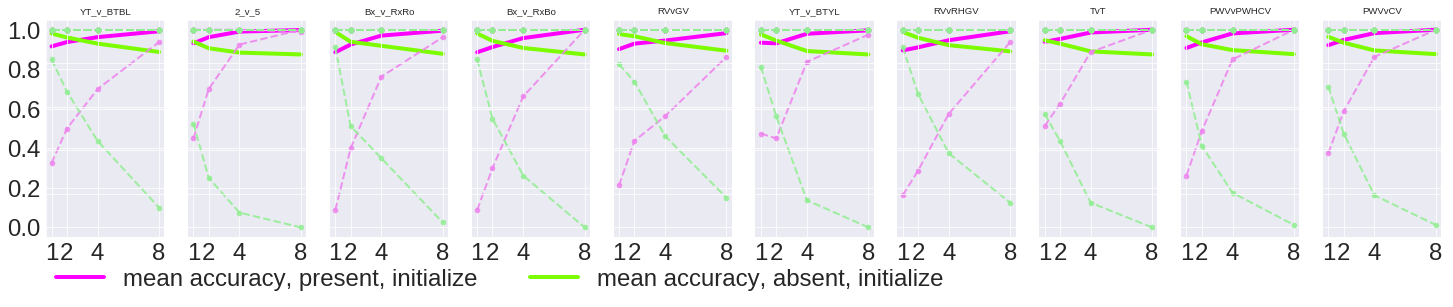

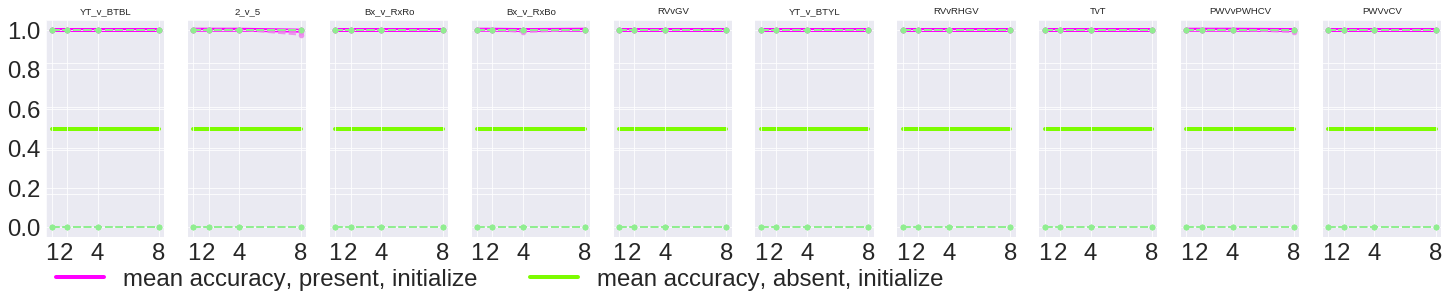

In [39]:
plot_classify_and_detect(df_all, 'alexnet', cmaps, conditions=['present', 'absent'], methods=['initialize'])

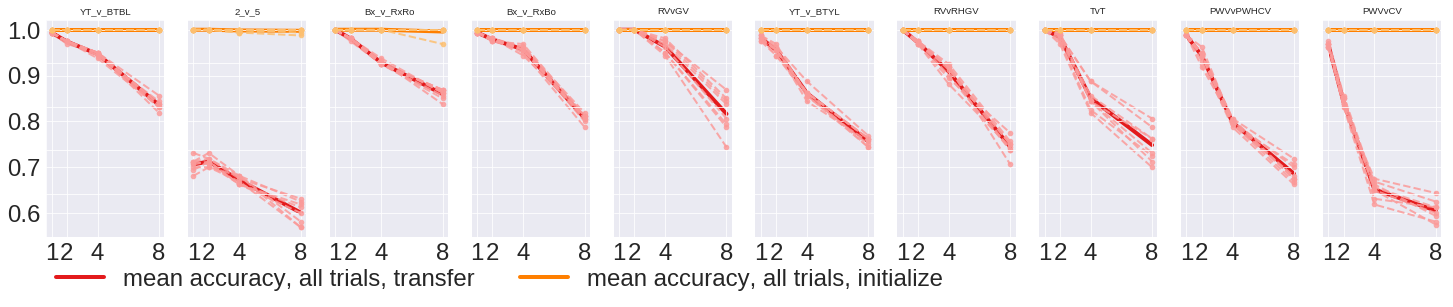

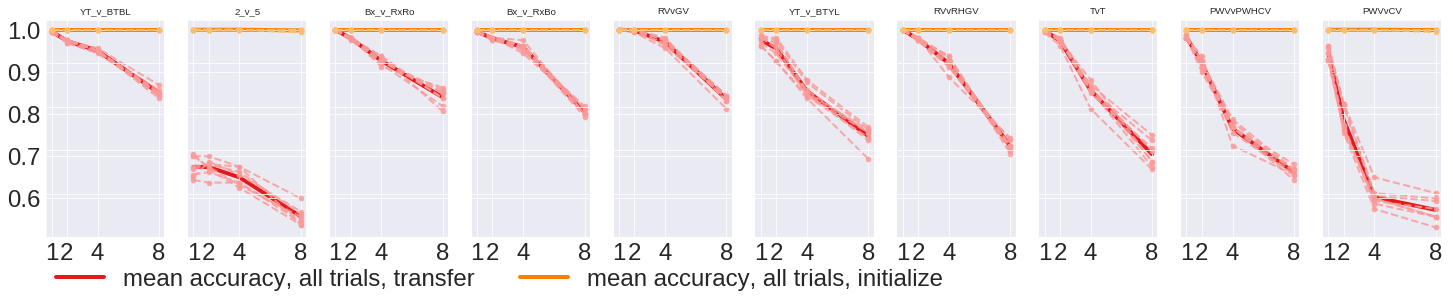

In [40]:
plot_classify_and_detect(df_all, 'CORnet_Z', cmaps, conditions=['both'])

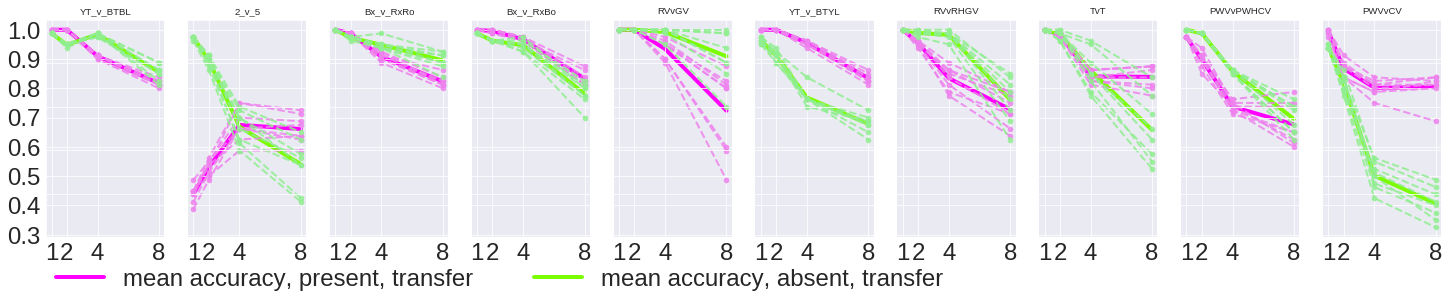

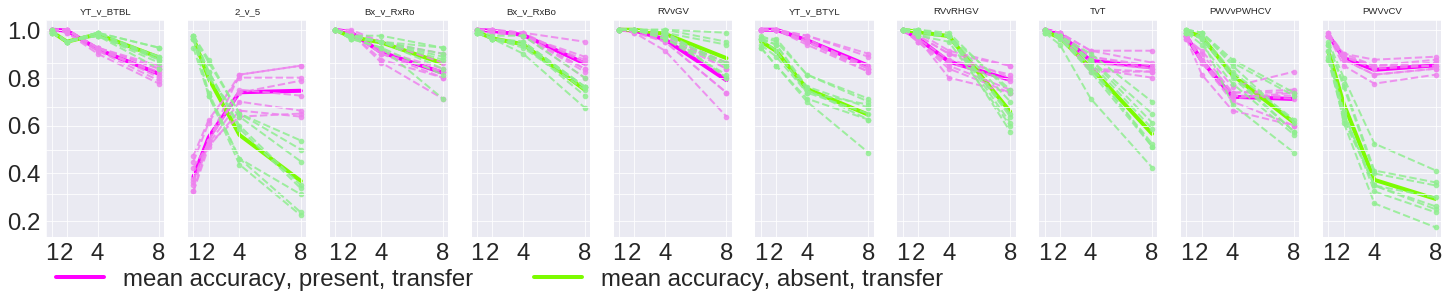

In [41]:
plot_classify_and_detect(df_all, 'CORnet_Z', cmaps, conditions=['present', 'absent'], methods=['transfer'])

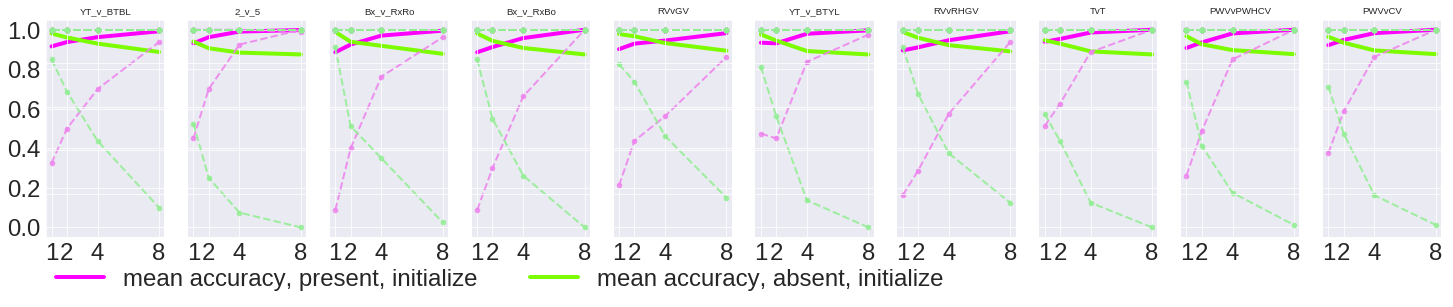

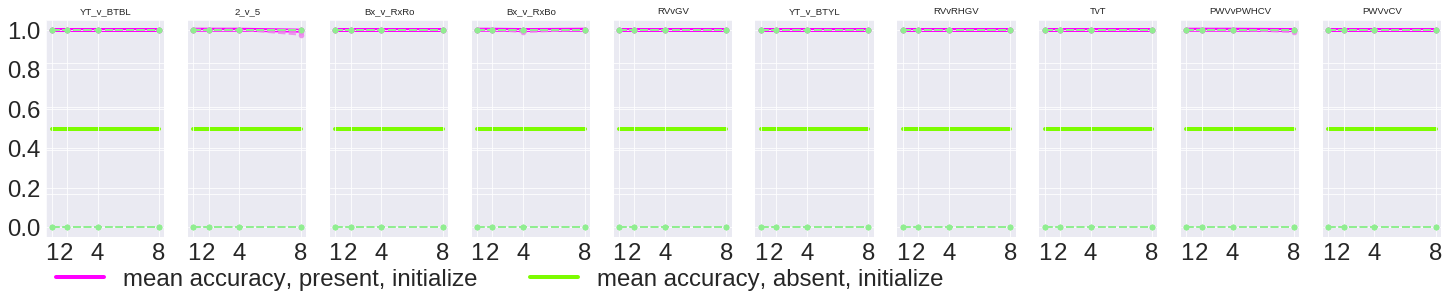

In [42]:
plot_classify_and_detect(df_all, 'alexnet', cmaps, conditions=['present', 'absent'], methods=['initialize'])

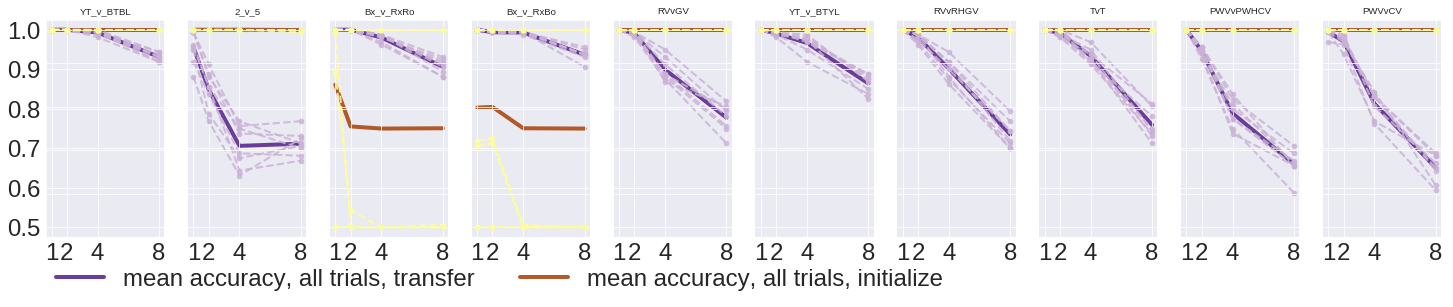

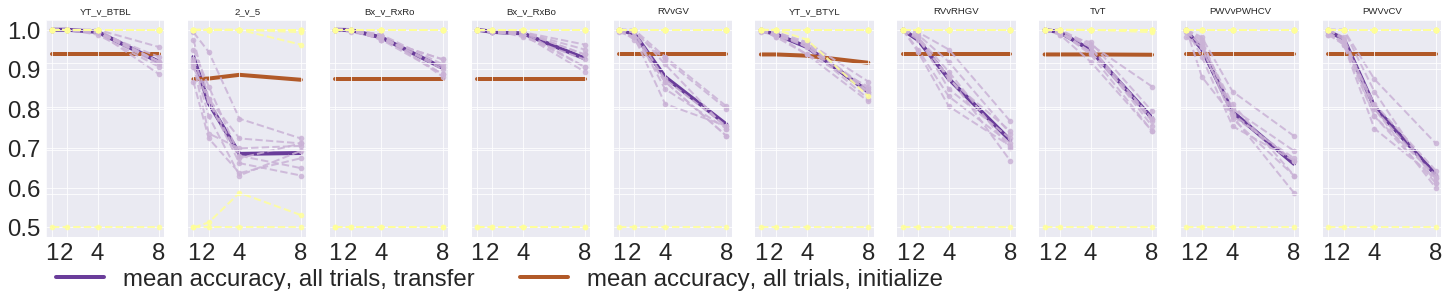

In [43]:
plot_classify_and_detect(df_all, 'VGG16', cmaps, conditions=['both'])

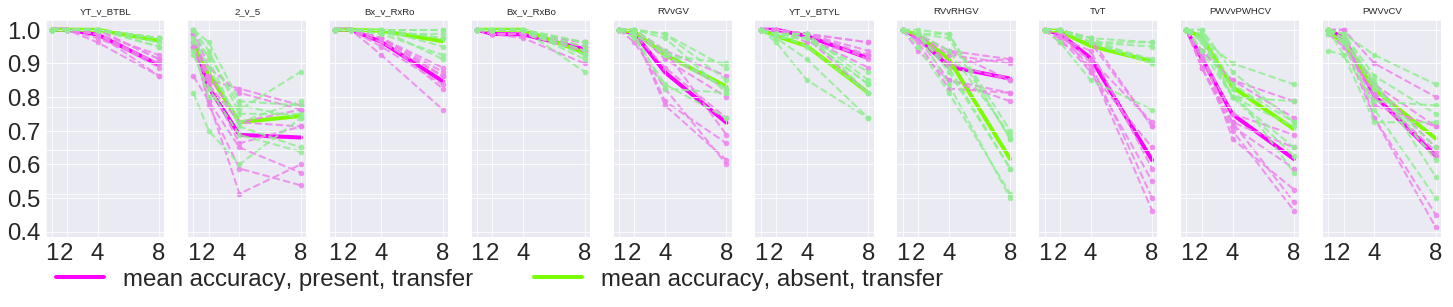

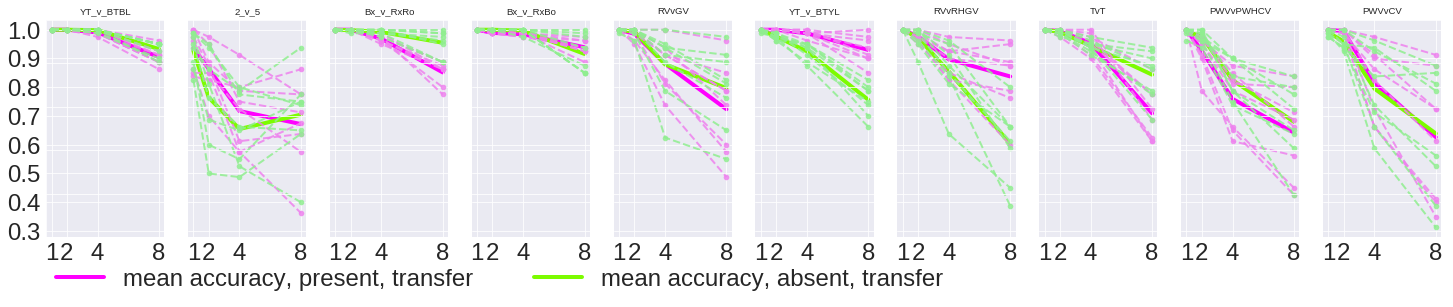

In [44]:
plot_classify_and_detect(df_all, 'VGG16', cmaps, conditions=['present', 'absent'], methods=['transfer'])

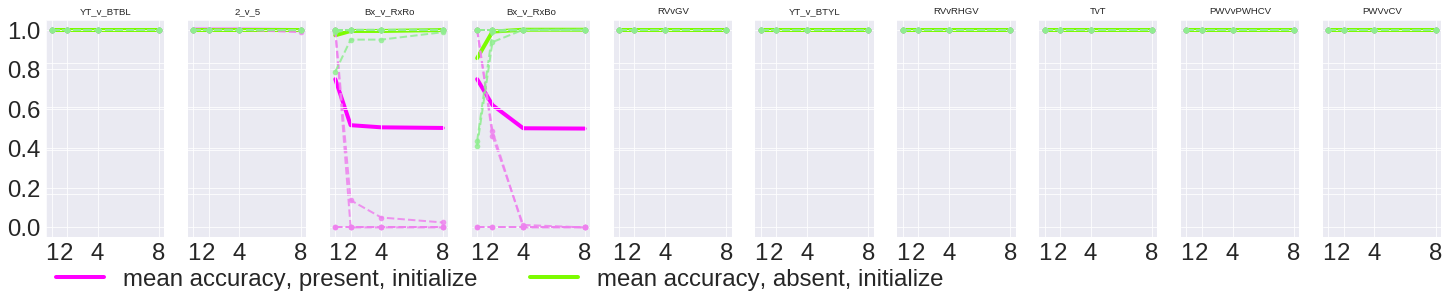

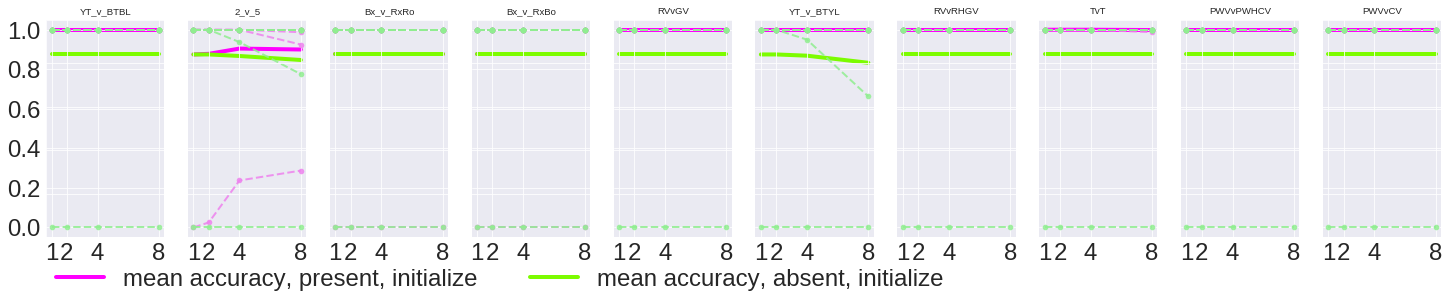

In [45]:
plot_classify_and_detect(df_all, 'VGG16', cmaps, conditions=['present', 'absent'], methods=['initialize'])

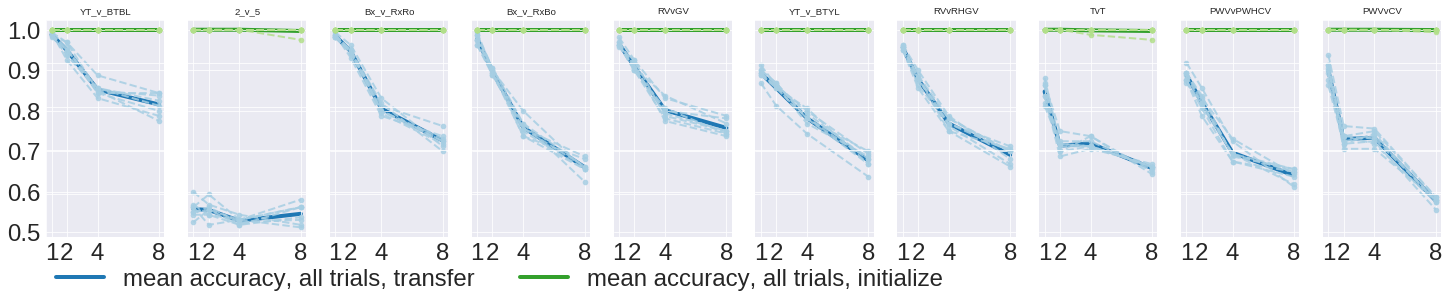

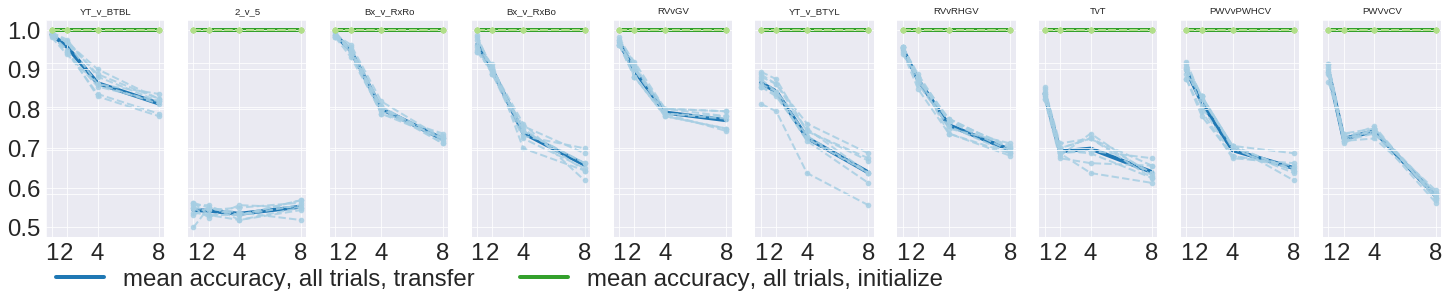

In [46]:
plot_classify_and_detect(df_all, 'CORnet_S', cmaps, conditions=['both'])

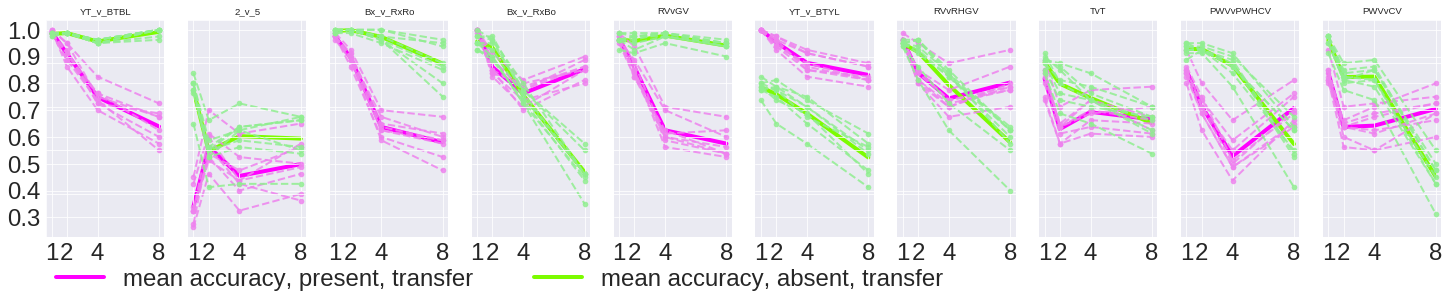

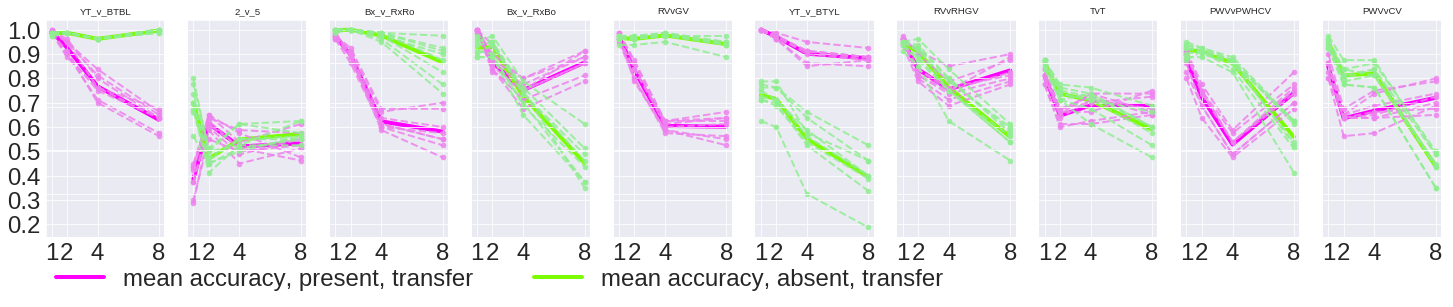

In [47]:
plot_classify_and_detect(df_all, 'CORnet_S', cmaps, conditions=['present', 'absent'], methods=['transfer'])

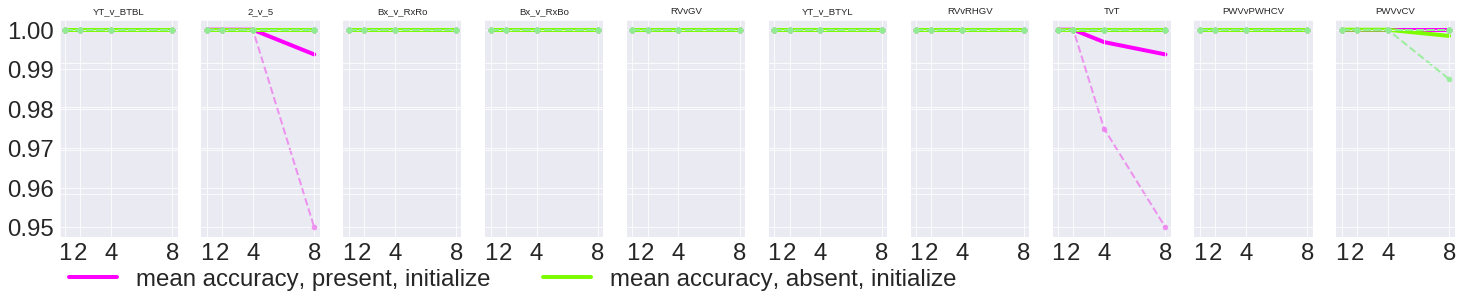

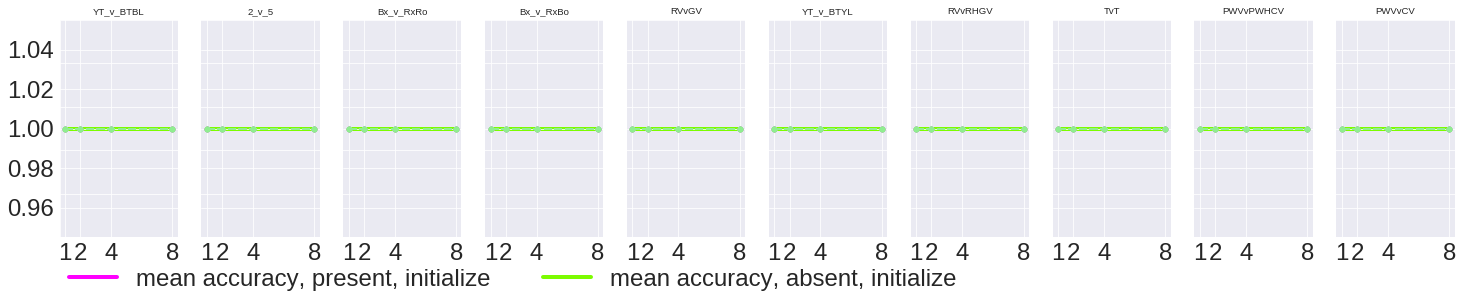

In [48]:
plot_classify_and_detect(df_all, 'CORnet_S', cmaps, conditions=['present', 'absent'], methods=['initialize'])